In [1]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
import calc11
import numpy as np
%matplotlib inline


In [2]:
fc = 0.850 # center frequency GHz
bw = 0.336 # bandwidth GHz
f1 = fc - bw/2.
f2 = fc + bw/2.
nchan = 336
lam1 = 3e8/f1/1e9
lam2 = 3e8/f2/1e9
print lam1, lam2
Npix = 256
ignore_ant = ['ak30','ak31','ak32','ak33','ak34','ak35','ak36']

0.439882697947 0.294695481336


In [3]:
cfile = calc11.ResultsFile('SB6357.im')

In [4]:
mjd = cfile.scans[0].first_mjd
p = cfile.scans[0].eval_src0_poly(mjd)
telnames = [t for t in cfile.telnames if t not in ignore_ant]
print 'Got', len(telnames), 'antennas'

Got 22 antennas


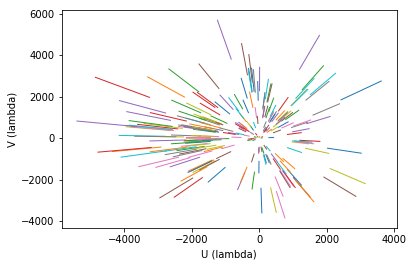

In [5]:
figure()
all_rlam = []
uvw = []
for ia1, a1 in enumerate(telnames):
    for ia2, a2 in enumerate(telnames[ia1+1:]):
        #u = [val[a1]['U (m)'] - val[a2]['U (m)'] for val in values]
        #v = [val[a1]['V (m)'] - val[a2]['V (m)'] for val in values]
        #w = [val[a1]['W (m)'] - val[a2]['W (m)'] for val in values]
        u = p[a1]['U (m)'] - p[a2]['U (m)']
        v = p[a1]['V (m)'] - p[a2]['V (m)']
        w = p[a1]['W (m)'] - p[a2]['W (m)']
        uvw.append((u,v,w))
        #print a1, a2, u, v, w
        ulam1, vlam1, wlam1 = u/lam1, v/lam1, w/lam1
        ulam2, vlam2, wlam2 = u/lam2, v/lam2, w/lam2
        r = np.sqrt(u*u + v*v)
        rlam1 = r/lam1
        rlam2 = r/lam2
        all_rlam.append((rlam1 - rlam2))
        plot([ulam1, ulam2], [vlam1, vlam2])
        
        
xlabel('U (lambda)')
ylabel('V (lambda)')
uvw = np.array(uvw)
uvwlam1 = uvw/lam1
uvwlam2 = uvw/lam2
        

In [6]:
assert(lam2 < lam1)

urange = uvwlam2[:, 0].max() - uvwlam2[:, 0].min()
vrange = uvwlam2[:, 1].max() - uvwlam2[:, 1].min()
lres = np.degrees(1.0/urange)*3600.
mres = np.degrees(1.0/vrange)*3600.
ucell = urange/float(Npix)
vcell = vrange/float(Npix)
lsize = np.degrees(1./ucell)
msize = np.degrees(1./vcell)
cellsize = min(ucell, vcell)

print 'UV range={:0.1f}x{:0.1f} lambda = {:0.1f}x{:0.1f} arcsec FoV: {:0.1f}x{:0.1f} deg'.format(urange, vrange, lres, mres,lsize, msize)

UV range=9025.3x9525.6 lambda = 22.9x21.7 arcsec FoV: 1.6x1.5 deg


In [7]:
# loop through baselines, working out the rounded uv cells where each one starts and stops
uvcell_start = np.round(uvwlam1/cellsize)
uvcell_end = np.round(uvwlam2/cellsize)

# radius in uv at which the track starts
rstart = np.sqrt(uvcell_start[:, 0]**2 + uvcell_start[:, 1]**2)
# radius at which it ends
rend = np.sqrt(uvcell_end[:, 0]**2 + uvcell_end[:, 1]**2)
rdist = rend - rstart 
print 'Radial distances', len(rdist), 'baselines', rdist.max(), rdist.min(), rdist.mean(), rdist.sum(), 'max/min/mean/sum'


Radial distances 231 baselines 54.12589865564284 1.0 20.25779902931949 4679.551575772802 max/min/mean/sum


Text(0,0.5,'Number of baselines')

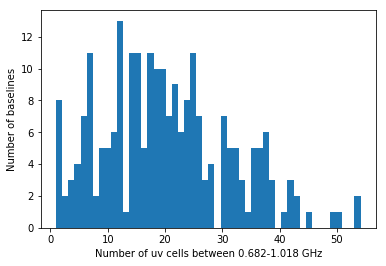

In [8]:
hist(rdist, bins=50)
xlabel('Number of uv cells between {:0.3f}-{:0.3f} GHz'.format(f1,f2))
ylabel('Number of baselines')

In [9]:
print 'Required memory', rdist.sum()*512*1024*4/1e9, 'GBytes or', rdist.mean()*(30*29/2)*512*1024*4/1e9, 'GBytes for 30 antennas'

Required memory 9.813730946235083 GBytes or 18.480402431221908 GBytes for 30 antennas


In [10]:
print '30 antenna UV cells', rdist.mean()*(30*29/2)
print 'input rate', 30*29/2*336*1*64*2*1e3/1e9, 'Gbits/sec'

30 antenna UV cells 8812.142577753977
input rate 18.70848 Gbits/sec
